## Install Libraries

In [57]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout,Input,Embedding,Flatten,TextVectorization,Conv1D,GlobalMaxPooling1D,MaxPooling1D,GlobalAveragePooling1D
from keras.initializers import Constant
from keras.layers import Dense,LSTM,Bidirectional,Attention,Concatenate,GRU,BatchNormalization
import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')
import pickle
import pandas as pd
import jieba
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [59]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


##  Initiate Paths and Read Data

In [60]:
train_path = '../input/emotrainval/EmoTrain.csv'
balance_path = '../input/emotrainval/balanced_dataset.csv'
val_path = '../input/emotrainval/EmoVal.csv'

data_train = pd.read_csv(train_path)
data_test = pd.read_csv(val_path)
data_train.head()

,Unnamed: 0,text,praise,amusement,anger,disapproval,confusion,interest,sadness,fear,joy,love
0,0,Is there some scripture you could quote me? I'...,1,0,0,0,0,1,0,0,0,0
1,1,Good. Now we just need people to dislike commi...,1,0,0,0,0,0,0,0,0,0
2,2,This was driving me NUTS!,0,1,0,0,0,0,0,0,0,0
3,3,Thank you for your advice!,0,0,0,0,0,0,0,0,0,1
4,4,Some do. Some don't. Blanket generalizations a...,0,0,1,1,0,0,0,0,0,0


## Data Exploration part 1
- Count total occurences of each label 
- Plot the label distribution

praise
0    160122
1     29980
Name: count, dtype: int64
--------------------------------------------------
amusement
0    176825
1     13277
Name: count, dtype: int64
--------------------------------------------------
anger
0    171814
1     18288
Name: count, dtype: int64
--------------------------------------------------
disapproval
0    175438
1     14664
Name: count, dtype: int64
--------------------------------------------------
confusion
0    126710
1     63392
Name: count, dtype: int64
--------------------------------------------------
interest
0    178092
1     12010
Name: count, dtype: int64
--------------------------------------------------
sadness
0    174721
1     15381
Name: count, dtype: int64
--------------------------------------------------
fear
0    186053
1      4049
Name: count, dtype: int64
--------------------------------------------------
joy
0    165852
1     24250
Name: count, dtype: int64
--------------------------------------------------
love
0    167577
1  

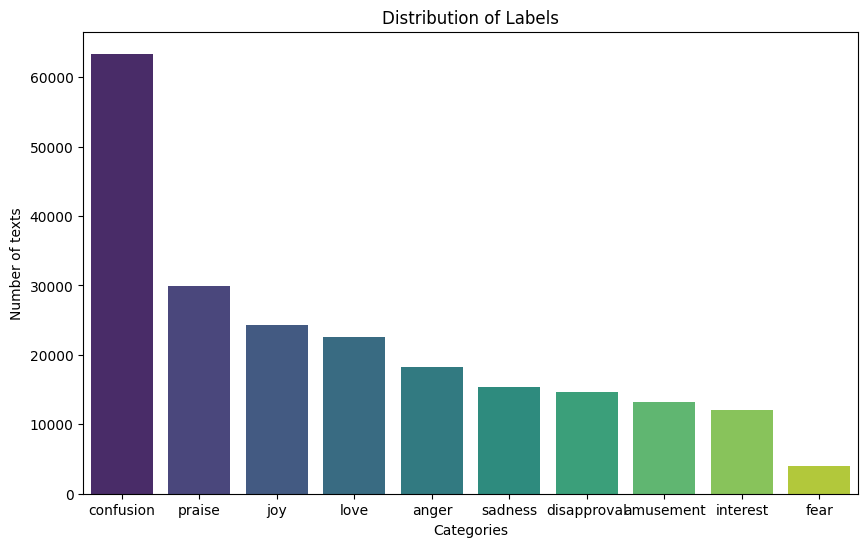

In [61]:
import matplotlib.pyplot as plt 
import seaborn as sns 
list_classes = ['praise', 'amusement', 'anger', 'disapproval', 'confusion', 'interest', 'sadness', 'fear', 'joy', 'love']

for column in list_classes:
    print(data_train[column].value_counts())
    print('-' * 50)

y_train = data_train[list_classes].values

df = pd.read_csv(train_path)
# Count total occurences of each label 
label_counts = df[list_classes].sum().sort_values(ascending=False)

# Plot the label distribution
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Distribution of Labels")
plt.xlabel("Categories")
plt.ylabel("Number of texts")
plt.show()

### multi-label distribution

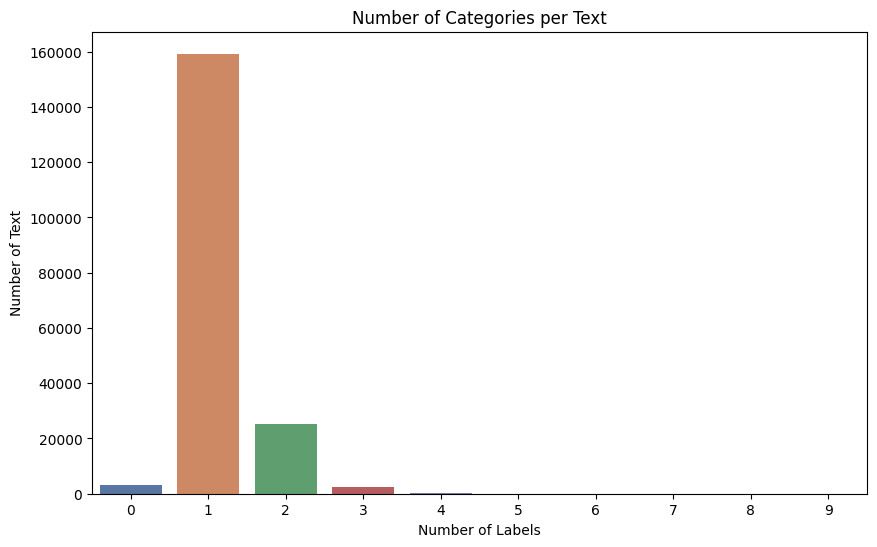

In [62]:
# Check the number of multi-label comments 
df['multi_lable_count'] = df[list_classes].sum(axis=1)
multi_label_distribution = df['multi_lable_count'].value_counts().sort_index()

# Plot multi-label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=multi_label_distribution.index, y=multi_label_distribution.values, palette="deep")
plt.title("Number of Categories per Text")
plt.xlabel("Number of Labels")
plt.ylabel("Number of Text")
plt.show()

### Balance Data set

## Preprocessing and Cleaning part 1
- Characters & stop_words
- Special words
- undersampling

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler

# def undersample_per_label(texts, labels):
#     """
#     Apply undersampling for each label independently in a multi-label dataset.
#     """
#     texts_resampled = []
#     labels_resampled = []

#     for label_idx in range(labels.shape[1]):
#         binary_labels = labels[:, label_idx]
        
#         # Combine texts and corresponding single-label targets
#         combined_data = [(text, label) for text, label in zip(texts, binary_labels)]
#         positive_samples = [item for item in combined_data if item[1] == 1]
#         negative_samples = [item for item in combined_data if item[1] == 0]

#         # Balance by sampling an equal number from positive and negative classes
#         minority_size = len(positive_samples)
#         negative_samples = negative_samples[:minority_size]

#         balanced_samples = positive_samples + negative_samples
#         texts_resampled.extend([item[0] for item in balanced_samples])
#         labels_resampled.extend([[1 if i == label_idx else 0 for i in range(labels.shape[1])] for item in balanced_samples])

#     return texts_resampled, np.array(labels_resampled)

# def preprocess_data(train_data, val_data):
#     # Extract texts and labels
#     train_texts, train_labels = train_data['text'], train_data.iloc[:, 2:].values
#     val_texts, val_labels = val_data['text'], val_data.iloc[:, 2:].values

#     # Apply per-label undersampling
#     train_texts, train_labels = undersample_per_label(train_texts.tolist(), train_labels)

#     return train_texts, train_labels, val_texts.tolist(), val_labels


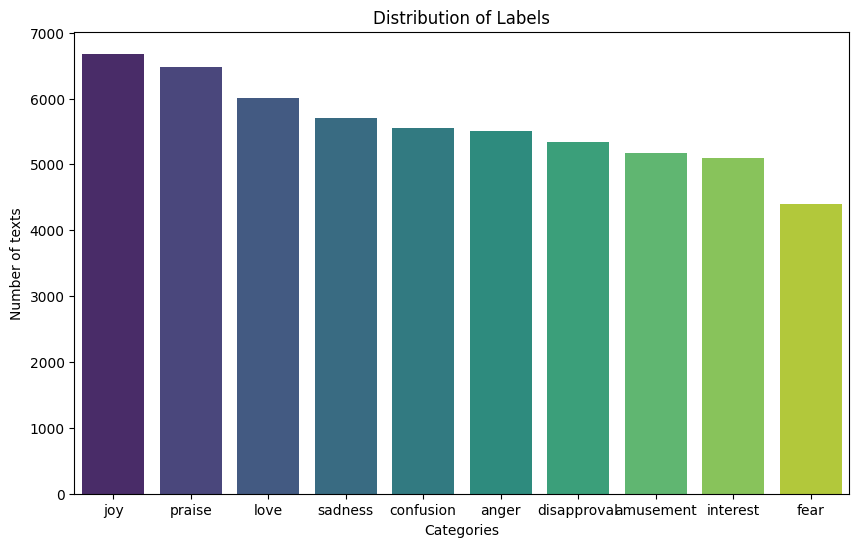

In [63]:
balance_data = pd.read_csv(balance_path)

# Count total occurences of each label 
label_counts = balance_data[list_classes].sum().sort_values(ascending=False)

# Plot the label distribution
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Distribution of Labels")
plt.xlabel("Categories")
plt.ylabel("Number of texts")
plt.show()

With under sampling and other methods doesn't achieve accuracy

In [64]:
x_train=data_train['text']

# Text Preprocessing
def clean(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)
    
def clean1(text,words_to_remove=[]):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in words_to_remove]
    return ' '.join(words)
    
x_train_cleaned = x_train.apply(clean)

print(x_train[0])
print(x_train_cleaned[0])


Is there some scripture you could quote me? I'd like to read up on it just to be sure for myself
scripture could quote id like read sure


## Data Exploration part 2
- Get unique words from Text in a specific category
- Analyze unique words in each Text category
- Display top 10 words in each class

('name', 'good', 'like', 'great', 'im', 'thats', 'one', 'love', 'get', 'really')


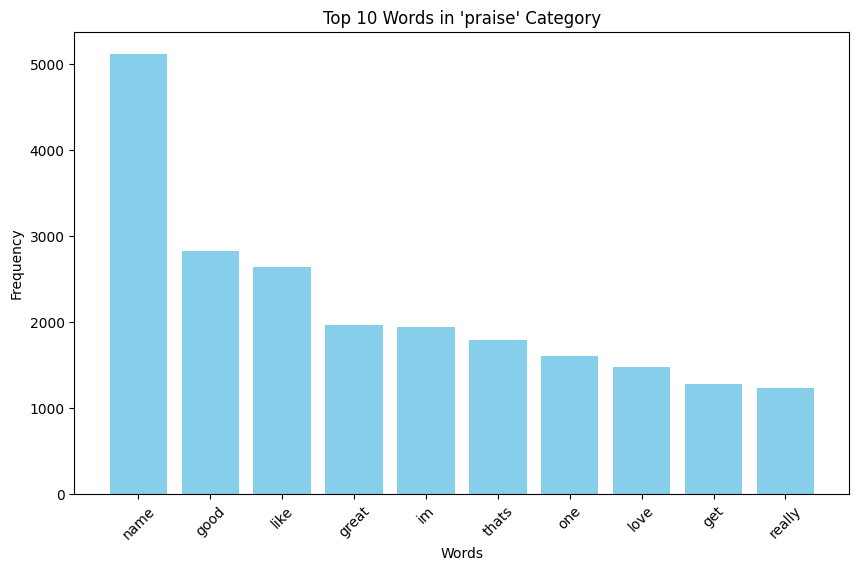

('lol', 'name', 'im', 'like', 'haha', 'thats', 'funny', 'one', 'fun', 'love')


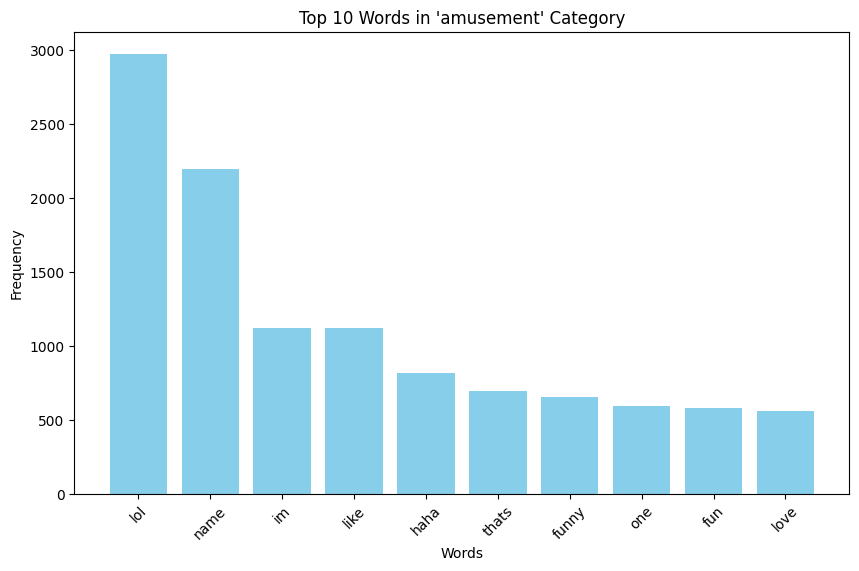

('name', 'dont', 'like', 'people', 'im', 'get', 'fuck', 'hate', 'one', 'fucking')


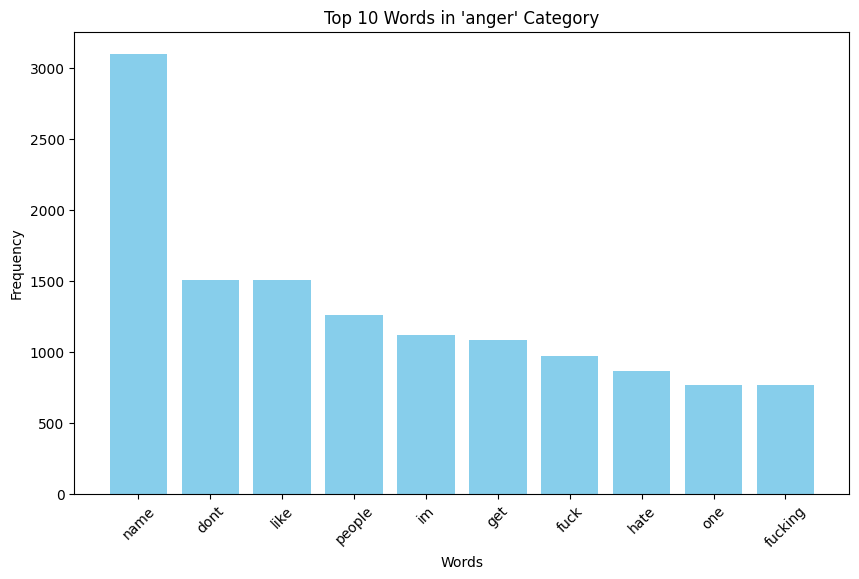

('name', 'dont', 'like', 'im', 'thats', 'people', 'think', 'cant', 'get', 'one')


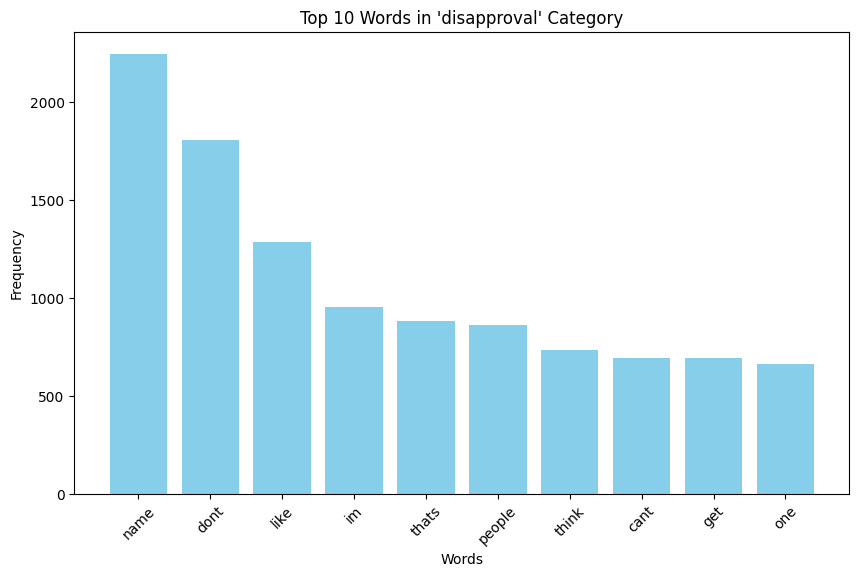

('name', 'like', 'dont', 'im', 'get', 'one', 'people', 'know', 'would', 'think')


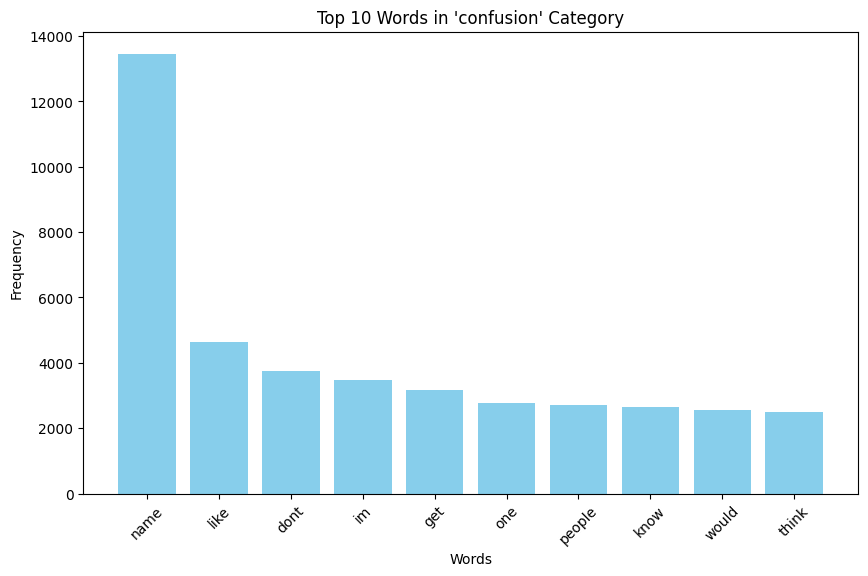

('name', 'like', 'im', 'would', 'want', 'wish', 'get', 'know', 'dont', 'one')


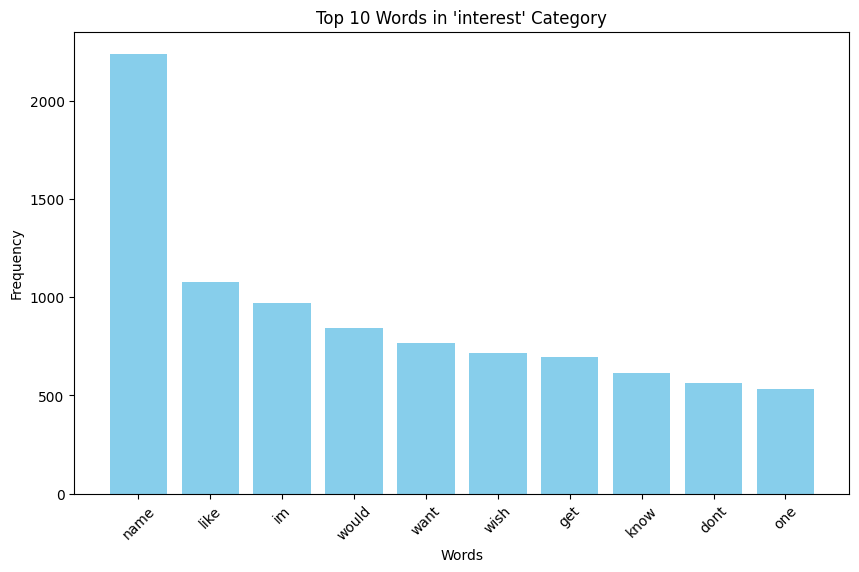

('name', 'sorry', 'im', 'like', 'bad', 'dont', 'get', 'sad', 'feel', 'one')


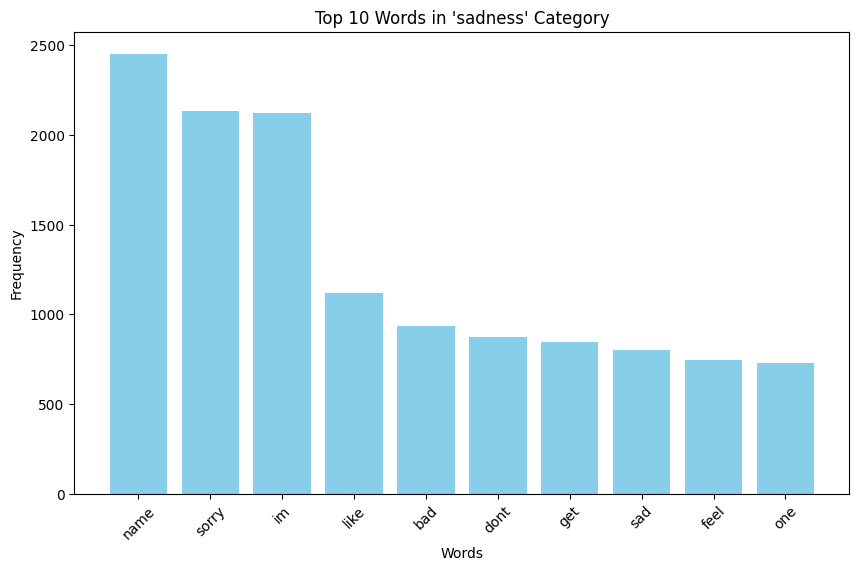

('name', 'im', 'like', 'dont', 'get', 'terrible', 'scared', 'thats', 'afraid', 'would')


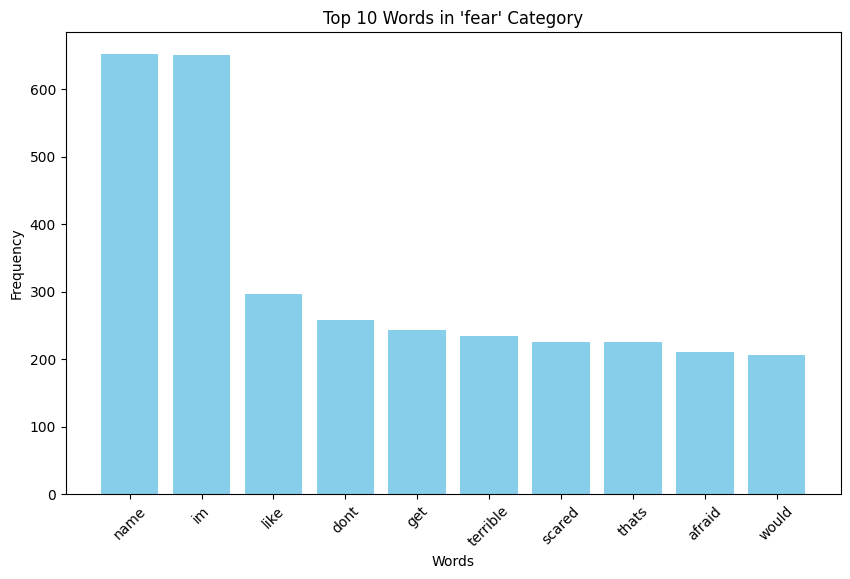

('name', 'im', 'like', 'hope', 'good', 'get', 'one', 'would', 'happy', 'dont')


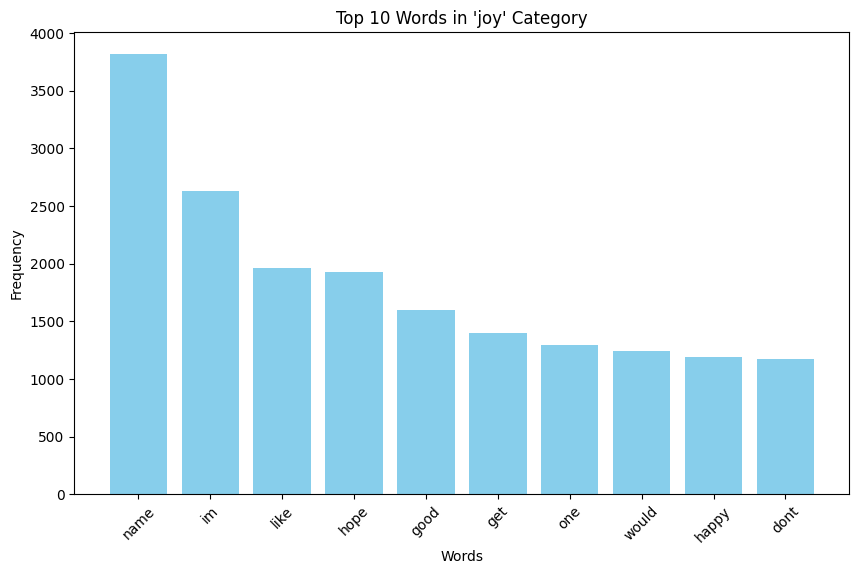

('love', 'thanks', 'name', 'thank', 'like', 'im', 'good', 'get', 'dont', 'much')


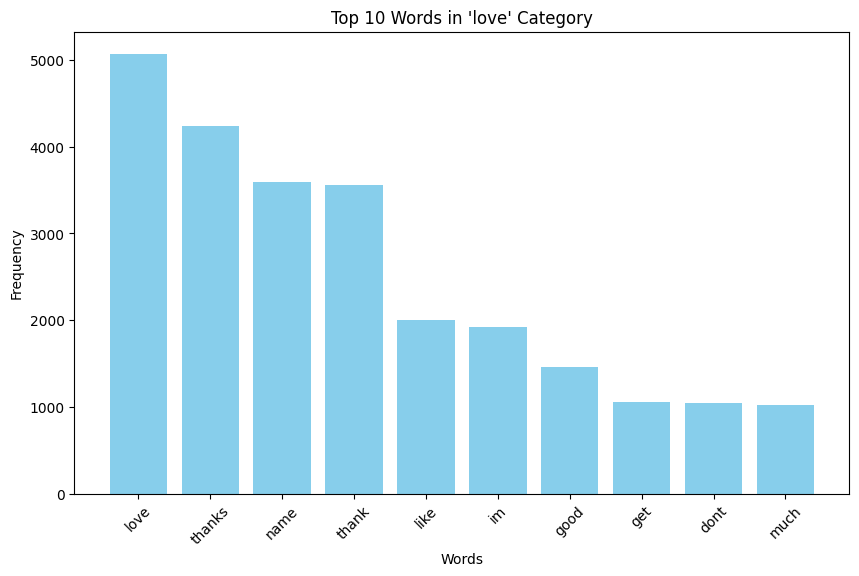

In [65]:
from collections import Counter

# Function to get unique words from Text in a specific category
def get_unique_words(comments):
    # Split all comments into words
    all_words = " ".join(comments).split()
    # Count the frequency of each word
    return Counter(all_words)  

def words_freq(x_train_cleaned):
    df['cleaned_text'] = x_train_cleaned
    # Analyze unique words in each Text category
    unique_words_per_category = {} 
    
    for label in list_classes:
        # Filter comments for the label
        category_texts = df[df[label] == 1]['cleaned_text']  
        word_counts = get_unique_words(category_texts)
        # Ensure the variable name is consistent
        unique_words_per_category[label] = word_counts 
    list_words = []
    # Display and visualize the top 10 unique words for each category
    for label, word_counts in unique_words_per_category.items():
        # Check if there are enough words in the category
        if len(word_counts) > 0:
            # Get the top 10 words and their counts
            top_words = word_counts.most_common(10)
            # Unpack into separate lists for words and counts
            words, counts = zip(*top_words) 
            print(words)
            list_words.append(words)
            # Plot the bar chart
            plt.figure(figsize=(10, 6))
            plt.bar(words, counts, color='skyblue')
            plt.title(f"Top 10 Words in '{label}' Category")
            plt.xlabel("Words")
            plt.ylabel("Frequency")
            plt.xticks(rotation=45)
            plt.show()
        else:
            print(f"No words available for category: {label}")
    return list_words
list_words = words_freq(x_train_cleaned)

## Preprocesses and Cleaning part 2
- Remove Common words

It will be effective on model because model will train on uncommon words and would be sensitive on each class 

In [66]:
def common_words(*word_lists):
    if not word_lists:
        return set()
    
    common_set = set(word_lists[0])
    for word_list in word_lists[1:]:
        common_set.intersection_update(word_list)
    
    return common_set

result = common_words(*list_words)
print("Words in all classes:", result)


Words in all classes: {'name', 'like', 'im'}


('good', 'great', 'thats', 'one', 'love', 'get', 'really', 'dont', 'look', 'would')


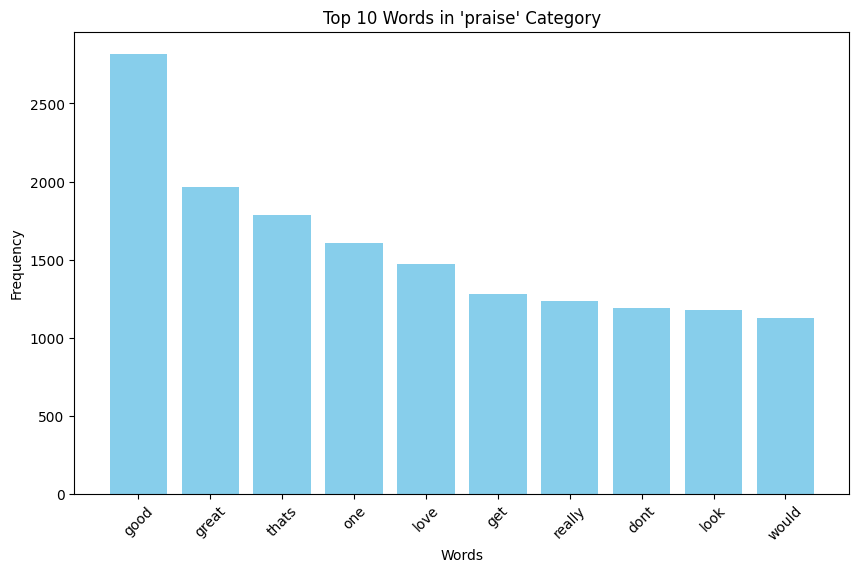

('lol', 'haha', 'thats', 'funny', 'one', 'fun', 'love', 'get', 'good', 'would')


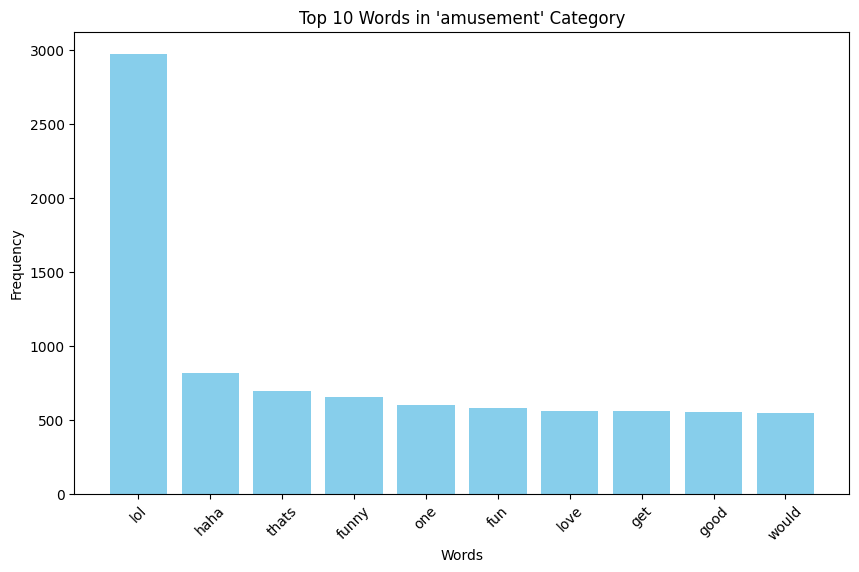

('dont', 'people', 'get', 'fuck', 'hate', 'one', 'fucking', 'youre', 'thats', 'make')


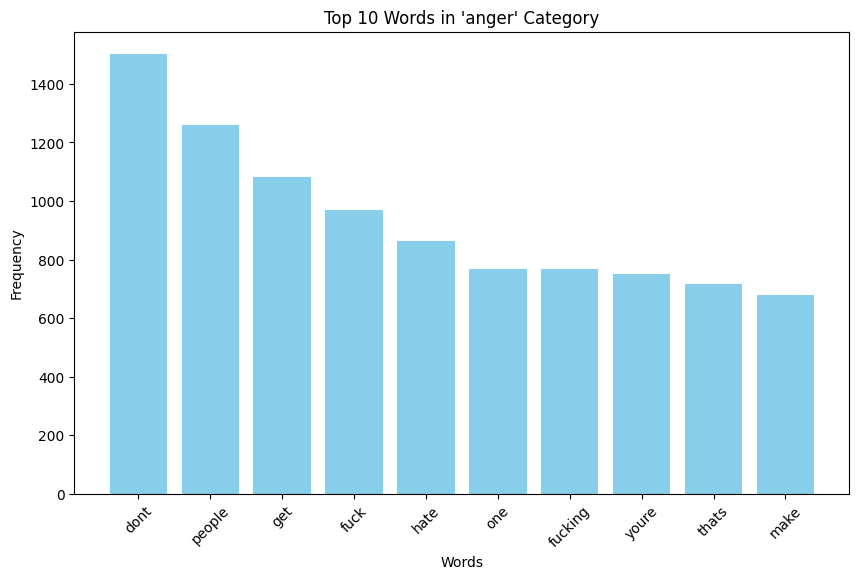

('dont', 'thats', 'people', 'think', 'cant', 'get', 'one', 'would', 'bad', 'really')


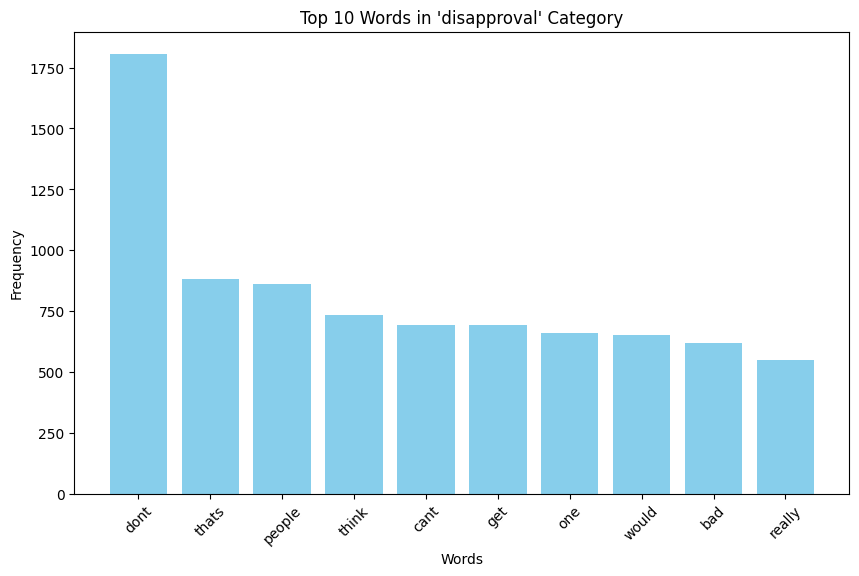

('dont', 'get', 'one', 'people', 'know', 'would', 'think', 'thats', 'time', 'really')


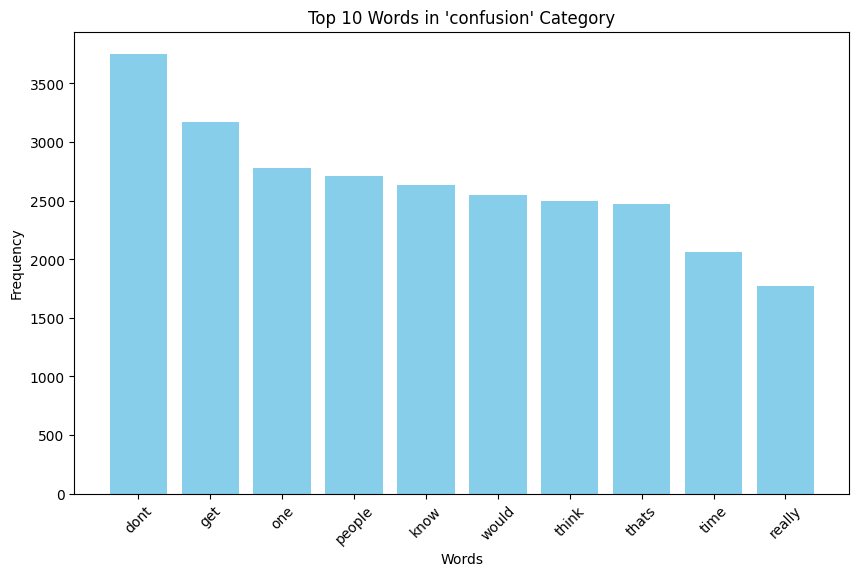

('would', 'want', 'wish', 'get', 'know', 'dont', 'one', 'see', 'really', 'people')


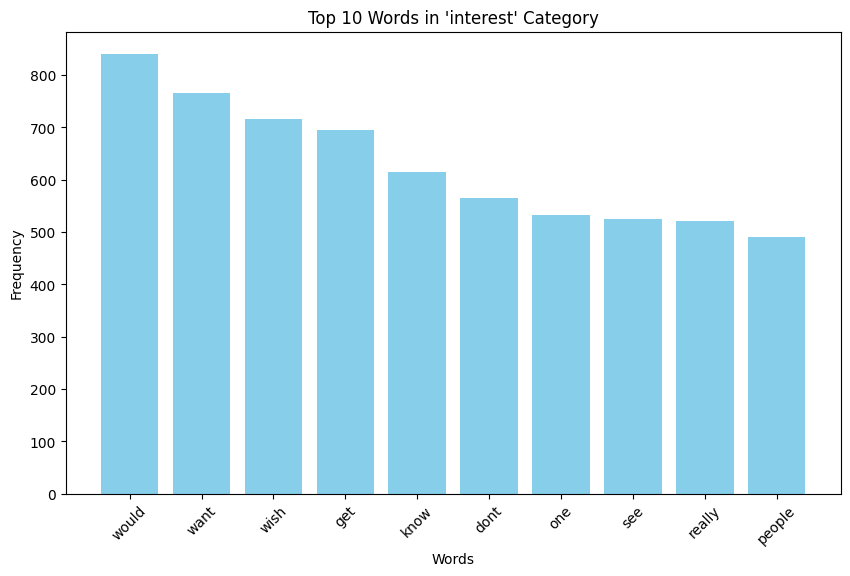

('sorry', 'bad', 'dont', 'get', 'sad', 'feel', 'one', 'really', 'people', 'thats')


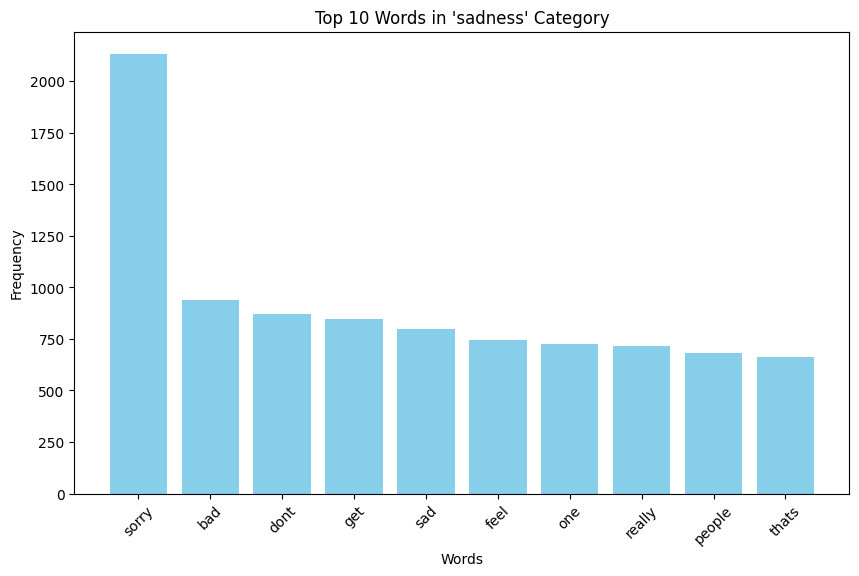

('dont', 'get', 'terrible', 'scared', 'thats', 'afraid', 'would', 'people', 'make', 'one')


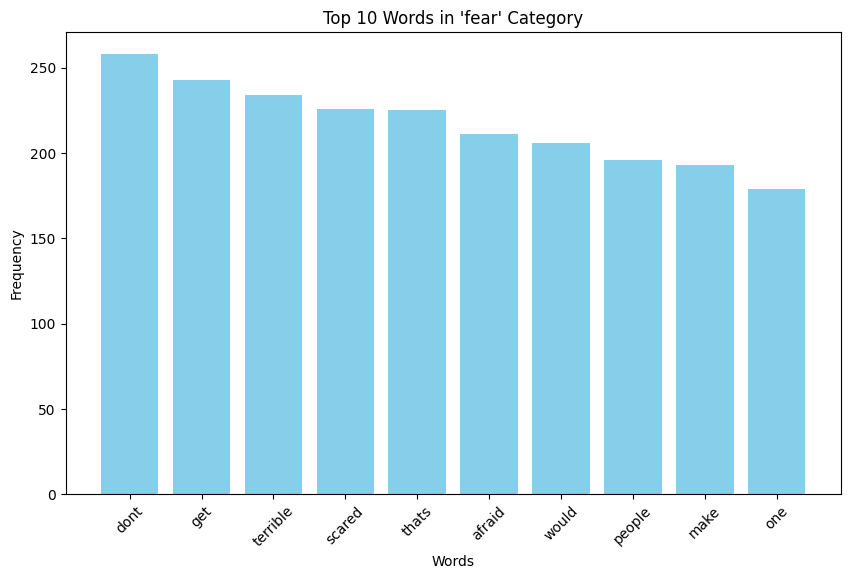

('hope', 'good', 'get', 'one', 'would', 'happy', 'dont', 'time', 'thats', 'glad')


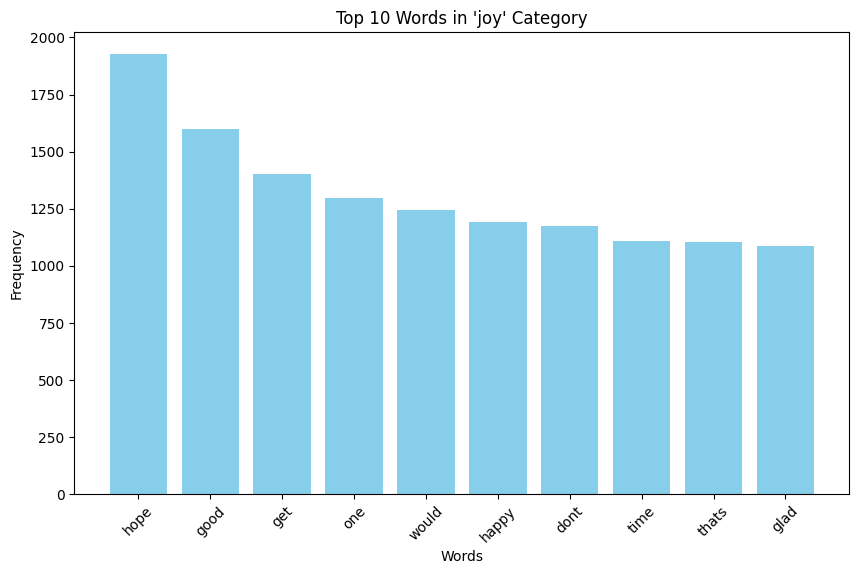

('love', 'thanks', 'thank', 'good', 'get', 'dont', 'much', 'one', 'really', 'know')


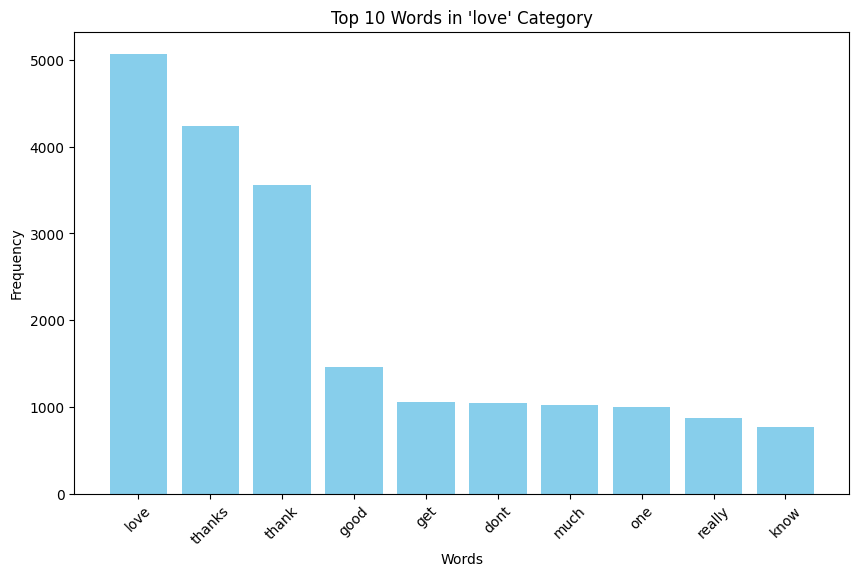

In [67]:
res = list(result)
res.append('people')
res.append('thats')
res.append('get')
res.append('one')
res.append('would')
res.append('really')
# res.append('dont')
x_train_cleaned = x_train_cleaned.apply(lambda text: clean1(text, res))

words = words_freq(x_train_cleaned)

## Tokenize and padding

Tokenizing is the process of breaking down text into smaller units, typically words or subwords, known as tokens. In natural language processing (NLP), tokenization is crucial for converting raw text into a format that can be understood and processed by machine learning models. For example, the sentence "I love NLP" might be tokenized into the tokens ["I", "love", "NLP"]. Padding, on the other hand, is the process of standardizing the length of tokenized sequences, especially when the input sentences vary in length. Since many machine learning models (such as those used in NLP) require inputs to be of a consistent size


In [68]:

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_cleaned)

X_train_sequences = tokenizer.texts_to_sequences(x_train_cleaned)

word_index = tokenizer.word_index
total_words = len(word_index)
print(total_words) #same as length of vocabulary

emb_len=len(tokenizer.index_word)+1
#getting the length of the maximum sequence in the dataset
max_length = max([len(w) for w in X_train_sequences])
print(max_length)

# Padding the sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=100, padding='post', truncating='post')


29545
29


## Create Model
The model developed for emotion classification was designed using Keras and includes the following components:

- Input Layer: Processes the tokenized and padded text sequences.

- Embedding Layer: Converts words into dense vectors of fixed size. The Embedding() layer helps capture semantic relationships between words.

- Bidirectional LSTM Layer: A recurrent layer (Bidirectional(LSTM())) that processes input sequences from both forward and backward directions, enhancing the capture of long-term dependencies in text.

- Attention Mechanism: Custom attention layers (Attention()) were added to focus on the most relevant parts of the input sequence.

- Dropout Layers: Implemented using Dropout() to randomly set a fraction of inputs to zero during training, helping prevent overfitting.

-Dense Layers: Fully connected layers (Dense()) transform features and provide the final classification output.

In [69]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers.schedules import ExponentialDecay


def create_model(lr, decay_step, decay_rate):

    # Define a decaying learning rate
    lr_schedule = ExponentialDecay(
        initial_learning_rate=lr, 
        decay_steps=decay_step,  
        decay_rate= decay_rate,  
        staircase=True  # Apply decay in discrete intervals
    )
    # Input layer
    input_layer = Input(shape=(100,))  # Specify max_len as the maximum sequence length
    
    # Embedding layer
    embedding_layer = Embedding(emb_len, 128)(input_layer)
    
    # Bidirectional LSTM layer replaced with Attention layer
    lstm_layer = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.3))(embedding_layer)
    attention = Attention()([lstm_layer, lstm_layer])  # Attention layer
    
    # 1D Convolutional layer
    conv1d_layer = Conv1D(64, kernel_size=3, activation='relu')(attention)
    # ////
    # conv1d_layer = BatchNormalization()(conv1d_layer)
    # GlobalMaxPooling1D layer
    global_max_pooling_layer = GlobalMaxPooling1D()(conv1d_layer)
    
    # Dense layers
    dense_layer_1 = Dense(128, activation='relu')(global_max_pooling_layer)
    #//////
    # dense_layer_1 = Dropout(0.3)(dense_layer_1)  # Prevent overfitting
    # dense_layer_2 = Dense(128, activation='relu')(dense_layer_1)
    output_layer = Dense(10, activation='sigmoid')(dense_layer_1)
    
    # Model creation
    model = Model(inputs=input_layer, outputs=output_layer)
    # custom_adam = Adam(learning_rate=0.0001)
    custom_adam = Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=custom_adam,loss='binary_crossentropy',metrics=['accuracy'])
    
    # model.compile(optimizer=custom_adam, loss=focal_loss(), metrics=['accuracy'])
    return model



# def focal_loss(alpha=0.25, gamma=2.0):
#     def loss(y_true, y_pred):
#         bce = K.binary_crossentropy(y_true, y_pred)
#         p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
#         return K.mean(alpha * (1 - p_t) ** gamma * bce)
#     return loss


model = create_model(0.01, 1000, 0.9)



### Summary of model

In [70]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 100, 128)       │      3,781,888 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 100, 256)       │        263,168 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 100, 256)       │              0 │ bidirectional_1[0][0], │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 98, 64)         │         49,216 │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 64)             │              0 │ conv1d_1[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │          8,320 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 10)             │          1,290 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,103,882 (15.66 MB)

 Trainable params: 4,103,882 (15.66 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model
- Save model in deferent check points
- Find best model accuracy with early stopping

In [71]:
import os
from keras.callbacks import EarlyStopping
checkpoint_path = '/kaggle/working/best_model.keras'  # Change the extension to .keras
checkpoint_dir = os.path.dirname(checkpoint_path)

# Make sure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
early_stop = EarlyStopping(monitor='val_loss',patience=2,verbose=True)

#Trainig the model
history = model.fit(X_train_padded,y_train,batch_size=128,epochs=4,validation_split=0.1,callbacks=[model_checkpoint_callback,early_stop])
model.save('/kaggle/working/final_model.keras')

Epoch 1/4
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 293s 217ms/step - accuracy: 0.3886 - loss: 0.3110 - val_accuracy: 0.4547 - val_loss: 0.2731
Epoch 2/4
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 287s 215ms/step - accuracy: 0.4677 - loss: 0.2663 - val_accuracy: 0.4514 - val_loss: 0.2721
Epoch 3/4
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 287s 215ms/step - accuracy: 0.4825 - loss: 0.2569 - val_accuracy: 0.4590 - val_loss: 0.2682
Epoch 4/4
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 288s 215ms/step - accuracy: 0.4960 - loss: 0.2492 - val_accuracy: 0.4566 - val_loss: 0.2699


## Evaluate and Predicate on Evaluation Data

In [72]:
from tensorflow.keras.models import load_model
import pandas as pd
val_path = '../input/emotrainval/EmoVal.csv'
data_test = pd.read_csv(val_path)
def pred_evaluate(data_test):
    model = load_model('/kaggle/working/final_model.keras')
    model.load_weights('/kaggle/working/best_model.keras')
    
    list_classes = ['praise', 'amusement', 'anger', 'disapproval', 'confusion', 'interest', 'sadness', 'fear', 'joy', 'love']
    x_test=data_test['text']
    label_test= data_test[list_classes]
    y_test = label_test[list_classes].values
    #Load best model
    x_test_cleaned = x_test.apply(clean)
    x_test_cleaned = x_test_cleaned.apply(lambda text: clean1(text, res))
    X_test_sequences = tokenizer.texts_to_sequences(x_test_cleaned)
    X_test_padded = pad_sequences(X_test_sequences, maxlen=100, padding='post', truncating='post')
    
    ## Evaluate Model
    
    loss, accuracy = model.evaluate(X_test_padded, y_test)
    print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')
    
    # Predictions
    predictions = model.predict(X_test_padded)
    print(predictions)
    target_columns = list_classes
    predictions = pd.DataFrame(predictions)
    output = pd.DataFrame(data={'praise': predictions[0], 'amusement': predictions[1],
                                'anger': predictions[2], 'disapproval': predictions[3],  'confusion': predictions[4],
                                'interest': predictions[5],'sadness': predictions[6],'fear': predictions[7],
                                'joy': predictions[8],'love': predictions[9]})
    output.to_csv('result.csv', index=False)
    
    predicted = output.values
    return predicted


predicted = pred_evaluate(data_test)

real_labels = data_test[list_classes].values
print(real_labels)

# print(predicted)

331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.4623 - loss: 0.2653
Validation Loss: 0.2661132216453552, Validation Accuracy: 0.46544215083122253
331/331 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step
[[7.24945441e-02 2.38130391e-02 3.60439718e-01 ... 9.49959364e-03
  8.59759301e-02 1.54460594e-02]
 [8.84373114e-02 1.70175526e-02 8.70041735e-03 ... 8.51911725e-04
  5.60157150e-02 1.26319528e-02]
 [1.95779633e-02 8.76654498e-03 4.30566753e-04 ... 3.29562645e-05
  1.31776175e-02 2.65951082e-03]
 ...
 [5.36145456e-02 9.50418971e-03 7.26674050e-02 ... 2.34013004e-03
  4.97387834e-02 3.95856099e-03]
 [1.06289014e-01 2.05751304e-02 3.87181081e-02 ... 2.99197133e-03
  7.91636631e-02 1.62424911e-02]
 [5.99543929e-01 3.32337804e-02 2.13173740e-02 ... 5.18102956e-04
  1.15187958e-01 4.72943597e-02]]
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


plot 

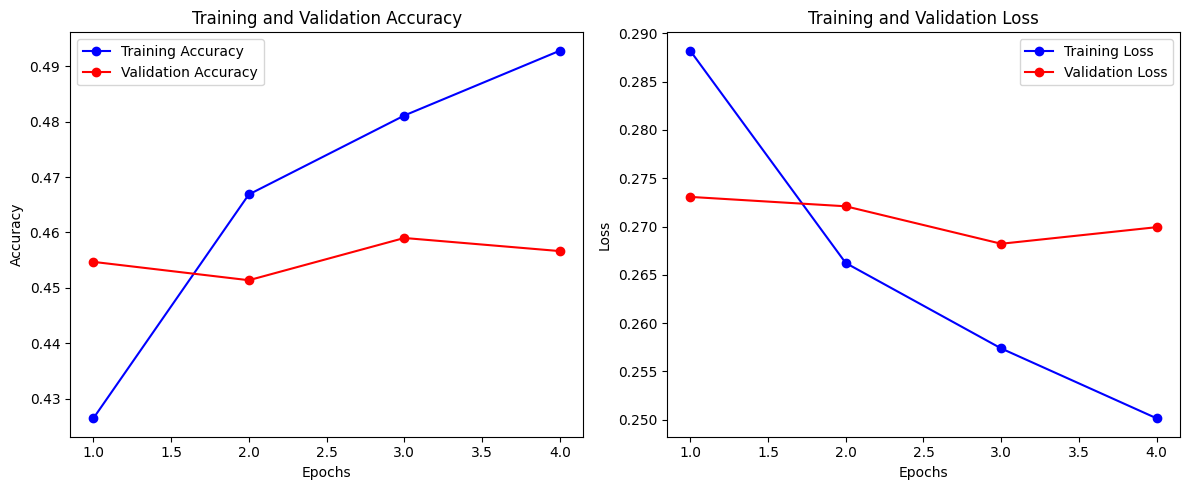

In [73]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

# Plot Accuracy and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Classification Score and Accuracy score

In [74]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, precision_recall_curve,accuracy_score
def accuracy_score(y_true, y_pred):
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    correct_predictions = 0
    
    # Loop over all samples and compare each prediction
    for i in range(len(y_true)):
        if np.array_equal(y_true[i], y_pred[i]):
            correct_predictions += 1
        if np.count_nonzero(y_true[i] != y_pred[i]) == 0:
            correct_predictions += 1
            
    accuracy = (correct_predictions / len(y_true)) 
    return accuracy
    
def report_preds(predicted, real_labels):
    num_classes = predicted.shape[1]
    best_thresholds = np.zeros(10)
    binarized_preds = np.zeros_like(predicted)
    
    # Find best threshold per class
    for i in range(num_classes):
        if np.sum(real_labels[:, i]) == 0:
            # No positive samples, default threshold to 0.5
            best_thresholds[i] = 0.5
            binarized_preds[:, i] = (predicted[:, i] >= best_thresholds[i]).astype(int)
        else:
            precision, recall, thresholds = precision_recall_curve(real_labels[:, i], predicted[:, i])
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
            best_index = np.nanargmax(f1_scores)
            
            if best_index < len(thresholds):
                best_thresholds[i] = thresholds[best_index]
            else:
                best_thresholds[i] = 0.5  # Fallback
            
            binarized_preds[:, i] = (predicted[:, i] >= best_thresholds[i]).astype(int)
    # print(binarized_preds)
    # Print the best thresholds
    print("Best thresholds for each class:", best_thresholds)
    
    # Print classification report with zero_division=0 to suppress warnings
    print("\nClassification Report:")
    print(classification_report(real_labels, binarized_preds, target_names=["praise", "amusement", "anger", "disapproval", "confusion", "interest", "sadness", "fear", "joy", "love"], zero_division=0))
    # Print accuracy
    accuracy = accuracy_score(real_labels, binarized_preds)
    print("\nAccuracy:", accuracy)
    
report_preds(predicted, real_labels)

Best thresholds for each class: [0.23754573 0.38804993 0.16447251 0.17485087 0.2585623  0.0899772
 0.21056196 0.27614686 0.25780609 0.27910522]

Classification Report:
              precision    recall  f1-score   support

      praise       0.43      0.55      0.48      1708
   amusement       0.54      0.51      0.53       727
       anger       0.35      0.50      0.41      1010
 disapproval       0.22      0.40      0.29       771
   confusion       0.48      0.77      0.59      3586
    interest       0.13      0.34      0.19       634
     sadness       0.46      0.44      0.45       831
        fear       0.54      0.49      0.51       248
         joy       0.42      0.34      0.38      1354
        love       0.69      0.63      0.66      1227

   micro avg       0.42      0.56      0.48     12096
   macro avg       0.43      0.50      0.45     12096
weighted avg       0.45      0.56      0.49     12096
 samples avg       0.46      0.57      0.49     12096


Accuracy: 0.547055

- Precision: the percentage of predicted positive instances that are correct.
  - higher precision means fewer false positives
- Recall: The percentage of actual positive instances that are correctly identitfied.
  - High recall means fewer false positives
- F1-Score: The harmonic mean of precision and recall
  - Balances the trade-off between precision and recall
- Support: The number of samples for each class
  - Imbalance in support impacts metrics like recall and F1-Score.

In [75]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_text(text):
    # Tokenize and pad the input text
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequences, maxlen=100, padding='post')

    # Get model predictions
    predictions = model.predict(padded_sequence)[0]

    # Create a DataFrame with the prediction results
    emotions = ['praise', 'amusement', 'anger', 'disapproval', 'confusion', 
                'interest', 'sadness', 'fear', 'joy', 'love']

    df = pd.DataFrame(data={'emotion': emotions, 'probability': predictions})
    
    return df

# Example usage
print(predict_text("I love this product, it's amazing!"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
       emotion  probability
0       praise     0.458680
1    amusement     0.271395
2        anger     0.002215
3  disapproval     0.002171
4    confusion     0.017296
5     interest     0.014164
6      sadness     0.000874
7         fear     0.000238
8          joy     0.317726
9         love     0.701229


## Test On API Interface

In [76]:
pip install nest_asyncio pyngrok fastapi uvicorn pydantic

Note: you may need to restart the kernel to use updated packages.


In [77]:
!ngrok authtoken '2sUa4gPKsJTS3NLSyrkhNWhnlqD_46tYuP3Tu7yX9uRgZx4mn'

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [78]:
from fastapi import FastAPI
from pydantic import BaseModel
import nest_asyncio
import uvicorn
from fastapi.responses import HTMLResponse
from fastapi.templating import Jinja2Templates
from starlette.requests import Request

from pyngrok import ngrok

# Open a tunnel on port 8000
public_url = ngrok.connect(8000)
print(f"Public URL: {public_url}")


Public URL: NgrokTunnel: "https://8026-34-168-30-66.ngrok-free.app" -> "http://localhost:8000"


In [79]:

nest_asyncio.apply()

app = FastAPI()

# Set up templates directory
templates = Jinja2Templates(directory="../input/emotrainval")

@app.get("/", response_class=HTMLResponse)
async def home(request: Request):
    return templates.TemplateResponse("home.html", {"request": request})

# Define Pydantic Model
class TextRequest(BaseModel):
    text: str

@app.post("/process/")
async def process_text(request: TextRequest):
    result = predict_text(request.text)
    # result = request.text
    return {"response": f"Text Labels: {result}"}


uvicorn.run(app, host="0.0.0.0", port=8000)


INFO:     Started server process [31]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     57.128.202.65:0 - "GET / HTTP/1.1" 200 OK
INFO:     57.128.202.65:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
INFO:     57.128.202.65:0 - "POST /process/ HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [31]


## Test On new TestDataSet

In [80]:
newTest_path = '../input/emotrainval/EmoTest-sample.csv'
newTest = pd.read_csv(newTest_path)
newTest['cleaned_text'] = newTest['text'].apply(clean)
newTest['cleaned_text'] = newTest['cleaned_text'].apply(lambda text: clean1(text, res))
newTest.head()

,index,text,praise,amusement,anger,disapproval,confusion,interest,sadness,fear,joy,love,cleaned_text
0,0,Yeah that's about what I found. Not that speci...,0,1,0,0,0,0,0,0,0,0,yeah thats found specific page got profile
1,1,"First bad melee, then off the sticks.. what next?",0,0,0,0,1,0,0,0,0,0,first bad melee stick next
2,2,I'm so sorry! I hope you are doing better!,1,0,0,0,0,0,1,0,1,0,sorry hope better
3,3,Tough deal haha. The recall just happened thou...,0,0,0,0,1,0,0,0,0,0,tough deal haha recall happened though may sti...
4,4,"[NAME], [NAME], [NAME], hey [NAME]. [NAME]! I’...",1,0,0,0,0,0,0,0,0,0,hey prostitute robot future


In [81]:
predicted1 = pred_evaluate(newTest)

real_labels1 = newTest[list_classes].values

report_preds(predicted1,real_labels1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4676 - loss: 0.2769
Validation Loss: 0.27356764674186707, Validation Accuracy: 0.4790000021457672
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
[[0.3660872  0.12891974 0.01785622 ... 0.00148959 0.1709401  0.06936322]
 [0.06563211 0.01481571 0.14250027 ... 0.01651528 0.07549029 0.01856161]
 [0.15793726 0.00643215 0.01612419 ... 0.08976602 0.4569764  0.20905134]
 ...
 [0.11625693 0.04161788 0.12672567 ... 0.03070317 0.11823587 0.1215912 ]
 [0.06671826 0.69231206 0.00865225 ... 0.001634   0.155453   0.01386417]
 [0.07163118 0.01605344 0.01670784 ... 0.00199539 0.06864841 0.01481591]]
Best thresholds for each class: [0.23441756 0.36054963 0.15550867 0.1067465  0.28634819 0.11508222
 0.20264363 0.28323385 0.2207395  0.28535339]

Classification Report:
              precision    recall  f1-score   support

      praise       0.46      0.61      0.52       167
   amusement       0.60      0.56      0.58        68
       anger       0.41      0.5